# Laboratorium 6 – Środowisko wieloagentowe

## Autorzy
- Kacper Cienkosz
- Miłosz Dubiel

# Wstęp teoretyczny

## Algorytm PPO
Proximal Policy Optimization (PPO) jest nowoczesnym algorytmem używanym do trenowania polityk (policy) w modelach, które podejmują decyzje sekwencyjne, np. w grach czy robotyce. PPO operuje na polityce, która określa prawdopodobieństwo wyboru akcji w danym stanie. Polityka jest aktualizowana w iteracyjny sposób, aby maksymalizować oczekiwaną sumę nagród.

### Kroki Algorytmu:
* Zbieranie Danych: Na początku algorytmu agent działa w środowisku przez pewien czas, zbierając dane na temat stanów, akcji, nagród oraz nowych stanów.
* Obliczanie Wartości Docelowych: Obliczane są wartości docelowe oraz przewidywania wartości dla stanów. Pomaga to w ocenie, jak dobre są akcje podejmowane przez agenta.
* Użycie Surrogate Objective: PPO wprowadza funkcję celu (surrogate objective), która mierzy, jak bardzo nowa polityka różni się od starej, a jednocześnie promuje zmiany, które przynoszą większe nagrody.
* Aktualizacja Polityki: Polityka jest aktualizowana, aby maksymalizować wartość surrogate objective, przy czym ogranicza się, jak bardzo polityka może się zmieniać w jednej iteracji (tzw. klipping, czyli ograniczenie gradientu).

### Zalety PPO
* Stabilność
* Prostota Implementacji
* Efektywność

## Środowisko FlagCapture
Środowisko FlagCapture jest przez autorów gymnasium określane jako "walka pamięci i informacji". Gra opiera się na znalezieniu ukrytej w siatce 9 x 7 flagi. Dwóch agentów porusza się po tej siatce i odkrywa pola, na których aktualnie się znajdują. Jako odpowiedź mogą dostać podpowiedź odnośnie kierunku, w którym powinni się kierować, żeby zdobyć flagę lub mogą natrafić na bombę, która przeniesie danego agenta do punktu początkowego.

## Rozważane hiperparametry
Z naszych eksperymentów wynikło, że na poprawny wynik uczenia mocno wpływa długość epizodu (oznaczona przez nas jako `max_cycles`). Jednakże, ze względu na niewystarczającą moc obliczeniową, nie byliśmy w stanie przeprowadzić procesu uczenia dla bardzo dużych wartości `max_cycles`. Spowodowało to też dosyć niską liczbę epizodów treningowych. Ponadto, ustawiliśmy współczynnik entropii na 0.01 oraz współczynnik funkcji wartości na 0.5.

## Wpływ hiperparametrów na uczenie w naszym przypadku
Tak jak napomknęliśmy powyżej: dobrym krokiem dla FlagCapture jest zwiększenie liczby kroków w pojedynczym epizodzie. Do dalszych eksperymentów w tym zakresie ogranicza nas moc obliczeniowa.


In [15]:
import dataclasses
import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
from torch.distributions.categorical import Categorical
import matplotlib.pyplot as plt

from supersuit import color_reduction_v0, frame_stack_v1, resize_v1

from pettingzoo.atari import flag_capture_v2

### Klasa opakowująca parametry

In [16]:
@dataclasses.dataclass
class AlgoParams:
    device: torch.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    ent_coef: float = 0.1
    vf_coef: float = 0.1
    clip_coef: float = 0.1
    gamma: float = 0.99
    lambd: float = 0.9
    batch_size: int = 32
    stack_size: int = 4
    frame_size: tuple = (64, 64)
    max_cycles: int = 125
    total_episodes: int = 100

### Implementacja Agenta z konwolucyjną siecią neuronową

In [17]:
class Agent(nn.Module):
    def __init__(self, num_actions):
        super().__init__()

        self.network = nn.Sequential(
            self._layer_init(nn.Conv2d(4, 32, 3, padding=1)),
            nn.MaxPool2d(2),
            nn.ReLU(),
            self._layer_init(nn.Conv2d(32, 64, 3, padding=1)),
            nn.MaxPool2d(2),
            nn.ReLU(),
            self._layer_init(nn.Conv2d(64, 128, 3, padding=1)),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Flatten(),
            self._layer_init(nn.Linear(128 * 8 * 8, 512)),
            nn.ReLU(),
        )
        self.actor = self._layer_init(nn.Linear(512, num_actions), std=0.01)
        self.critic = self._layer_init(nn.Linear(512, 1))

    def _layer_init(self, layer, std=np.sqrt(2), bias_const=0.0):
        torch.nn.init.orthogonal_(layer.weight, std)
        torch.nn.init.constant_(layer.bias, bias_const)
        return layer

    def get_value(self, x):
        return self.critic(self.network(x / 255.0))

    def get_action_and_value(self, x, action=None):
        hidden = self.network(x / 255.0)
        logits = self.actor(hidden)
        probs = Categorical(logits=logits)
        if action is None:
            action = probs.sample()
        return action, probs.log_prob(action), probs.entropy(), self.critic(hidden)

### Implementacja procesu uczenia i ewaluacji polityki

In [18]:
class PPOLearner:
    def __init__(self, agent_class, env, params: AlgoParams):
        self.losses = []
        self.policy_losses = []
        self.params = params
        self.env = env
        self.agent = agent_class(env.action_space(env.possible_agents[0]).n).to(params.device)
        self.optimizer = optim.Adam(self.agent.parameters(), lr=0.001, eps=1e-5)

        self.num_agents = len(env.possible_agents)
        self.observation_size = env.observation_space(env.possible_agents[0]).shape

        self.rb_obs = torch.zeros(
            (params.max_cycles, self.num_agents, params.stack_size, *params.frame_size)
        ).to(params.device)
        tensor_dims = (params.max_cycles, self.num_agents)
        self.rb_actions = torch.zeros(tensor_dims).to(params.device)
        self.rb_logprobs = torch.zeros(tensor_dims).to(params.device)
        self.rb_rewards = torch.zeros(tensor_dims).to(params.device)
        self.rb_terms = torch.zeros(tensor_dims).to(params.device)
        self.rb_values = torch.zeros(tensor_dims).to(params.device)

    def train(self):
        for episode in range(self.params.total_episodes):
            with torch.no_grad():
                next_obs, info = self.env.reset(seed=None)
                total_episodic_return = 0
                end_step = 0

                for step in range(0, self.params.max_cycles):
                    obs = self.batchify_obs(next_obs, self.params.device)
                    actions, logprobs, _, values = self.agent.get_action_and_value(obs)
                    next_obs, rewards, terms, truncs, infos = self.env.step(
                        self.unbatchify(actions, self.env)
                    )

                    self.rb_obs[step] = obs
                    self.rb_rewards[step] = self.batchify(rewards, self.params.device)
                    self.rb_terms[step] = self.batchify(terms, self.params.device)
                    self.rb_actions[step] = actions
                    self.rb_logprobs[step] = logprobs
                    self.rb_values[step] = values.flatten()
                    total_episodic_return += self.rb_rewards[step].cpu().numpy()

                    if any([terms[a] for a in terms]) or any([truncs[a] for a in truncs]):
                        end_step = step
                        break

            with torch.no_grad():
                rb_advantages = torch.zeros_like(self.rb_rewards).to(self.params.device)
                for t in reversed(range(end_step)):
                    delta = (
                            self.rb_rewards[t]
                            + self.params.gamma * self.rb_values[t + 1] * self.rb_terms[t + 1]
                            - self.rb_values[t]
                    )
                    rb_advantages[t] = delta + self.params.gamma * self.params.gamma * rb_advantages[t + 1]
                rb_returns = rb_advantages + self.rb_values

            # convert our episodes to batch of individual transitions
            b_obs = torch.flatten(self.rb_obs[:end_step], start_dim=0, end_dim=1)
            b_logprobs = torch.flatten(self.rb_logprobs[:end_step], start_dim=0, end_dim=1)
            b_actions = torch.flatten(self.rb_actions[:end_step], start_dim=0, end_dim=1)
            b_returns = torch.flatten(rb_returns[:end_step], start_dim=0, end_dim=1)
            b_values = torch.flatten(self.rb_values[:end_step], start_dim=0, end_dim=1)
            b_advantages = torch.flatten(rb_advantages[:end_step], start_dim=0, end_dim=1)

            b_index = np.arange(len(b_obs))
            clip_fracs = []
            for repeat in range(3):
                np.random.shuffle(b_index)
                for start in range(0, len(b_obs), self.params.batch_size):
                    end = start + self.params.batch_size
                    batch_index = b_index[start:end]

                    _, newlogprob, entropy, value = self.agent.get_action_and_value(
                        b_obs[batch_index], b_actions.long()[batch_index]
                    )
                    logratio = newlogprob - b_logprobs[batch_index]
                    ratio = logratio.exp()

                    with torch.no_grad():
                        old_approx_kl = (-logratio).mean()
                        approx_kl = ((ratio - 1) - logratio).mean()
                        clip_fracs.append(((ratio - 1.0).abs() > self.params.clip_coef).float().mean().item())

                    advantages = b_advantages[batch_index]
                    b_advantages[batch_index] = (advantages - advantages.mean()) / (advantages.std() + 1e-8)

                    pg_loss1 = -b_advantages[batch_index] * ratio
                    pg_loss2 = -b_advantages[batch_index] \
                        * torch.clamp(ratio, 1 - self.params.clip_coef, 1 + self.params.clip_coef)
                    pg_loss = torch.max(pg_loss1, pg_loss2).mean()

                    value = value.flatten()
                    v_loss_unclipped = (value - b_returns[batch_index]) ** 2
                    v_clipped = b_values[batch_index] + torch.clamp(
                        value - b_values[batch_index], -self.params.clip_coef, self.params.clip_coef,
                    )
                    v_loss_clipped = (v_clipped - b_returns[batch_index]) ** 2
                    v_loss_max = torch.max(v_loss_unclipped, v_loss_clipped)
                    v_loss = 0.5 * v_loss_max.mean()

                    entropy_loss = entropy.mean()
                    loss = pg_loss - self.params.ent_coef * entropy_loss + v_loss * self.params.vf_coef

                    self.optimizer.zero_grad()
                    loss.backward()
                    self.optimizer.step()

            y_pred, y_true = b_values.cpu().numpy(), b_returns.cpu().numpy()
            var_y = np.var(y_true)
            explained_var = np.nan if var_y == 0 else 1 - np.var(y_true - y_pred) / var_y

            self.losses.append(v_loss.item())
            self.policy_losses.append(pg_loss.item())

            self.visualize_step(
                episode,
                total_episodic_return,
                end_step,
                v_loss,
                pg_loss,
                old_approx_kl,
                approx_kl,
                clip_fracs,
                explained_var
            )

    def batchify_obs(self, obs, device):
        obs = np.stack([obs[a] for a in obs], axis=0)
        obs = obs.transpose(0, -1, 1, 2)
        obs = torch.tensor(obs).to(device)

        return obs

    def batchify(self, x, device):
        x = np.stack([x[a] for a in x], axis=0)
        x = torch.tensor(x).to(device)

        return x

    def unbatchify(self, x, env):
        x = x.cpu().numpy()
        x = {a: x[i] for i, a in enumerate(env.possible_agents)}

        return x

    def visualize_step(
            self,
            episode,
            total_episodic_return,
            end_step,
            v_loss,
            pg_loss,
            old_approx_kl,
            approx_kl,
            clip_fracs,
            explained_var
    ) -> None:
        print(f"Training episode {episode}")
        print(f"Episodic Return: {np.mean(total_episodic_return)}")
        print(f"Episode Length: {end_step}")
        print("")
        print(f"Value Loss: {v_loss.item()}")
        print(f"Policy Loss: {pg_loss.item()}")
        print(f"Old Approx KL: {old_approx_kl.item()}")
        print(f"Approx KL: {approx_kl.item()}")
        print(f"Clip Fraction: {np.mean(clip_fracs)}")
        print(f"Explained Variance: {explained_var.item()}")
        print("\n-------------------------------------------\n")

    def render_policy(self, env):
        self.agent.eval()

        with torch.no_grad():
            # render 5 episodes out
            for episode in range(5):
                obs, infos = env.reset(seed=None)
                obs = self.batchify_obs(obs, self.params.device)
                terms = [False]
                truncs = [False]
                while not any(terms) and not any(truncs):
                    actions, logprobs, _, values = self.agent.get_action_and_value(obs)
                    obs, rewards, terms, truncs, infos = env.step(self.unbatchify(actions, env))
                    obs = self.batchify_obs(obs, self.params.device)
                    terms = [terms[a] for a in terms]
                    truncs = [truncs[a] for a in truncs]

### Proces uczenia

In [6]:
params = AlgoParams(max_cycles=1000, total_episodes=50, ent_coef=0.01, vf_coef=0.5)

In [7]:
train_env = flag_capture_v2.parallel_env(render_mode="rgb_array", max_cycles=params.max_cycles)
train_env = color_reduction_v0(train_env)
train_env = resize_v1(train_env, *params.frame_size)
train_env = frame_stack_v1(train_env, stack_size=params.stack_size)

In [8]:
ppo_learner = PPOLearner(Agent, train_env, params)
ppo_learner.train()

Training episode 0
Episodic Return: 2.5
Episode Length: 999

Value Loss: 363.03338623046875
Policy Loss: 0.0053311982192099094
Old Approx KL: -0.02066000923514366
Approx KL: 0.0029394328594207764
Clip Fraction: 0.6654856387900296
Explained Variance: -0.0004976987838745117

-------------------------------------------
Training episode 1
Episodic Return: 2.5
Episode Length: 999

Value Loss: 45168.44140625
Policy Loss: 0.016535155475139618
Old Approx KL: 0.01887243054807186
Approx KL: 0.002828951459378004
Clip Fraction: 0.21801776281267246
Explained Variance: -0.00019276142120361328

-------------------------------------------
Training episode 2
Episodic Return: 2.5
Episode Length: 999

Value Loss: 440.6608581542969
Policy Loss: 0.013443036004900932
Old Approx KL: -0.006924203597009182
Approx KL: 0.0005110119236633182
Clip Fraction: 0.050595238095238096
Explained Variance: -0.00037229061126708984

-------------------------------------------
Training episode 3
Episodic Return: 0.0
Episode L

### Krzywa uczenia na podstawie _policy loss_

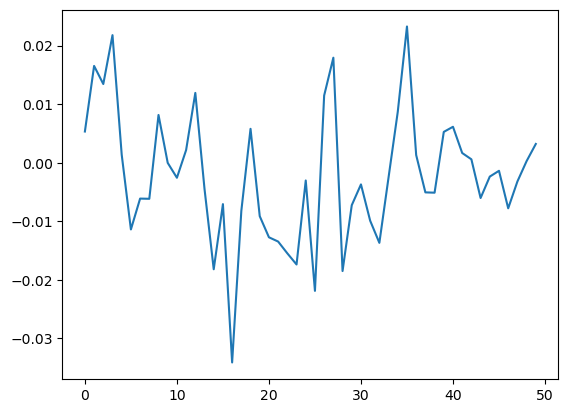

In [13]:
plt.plot(ppo_learner.policy_losses)

### Proces ewaluacji i wyświetlenia wyników uczenia w postaci gry

In [10]:
env = flag_capture_v2.parallel_env(render_mode="human")
env = color_reduction_v0(env)
env = resize_v1(env, *params.frame_size)
env = frame_stack_v1(env, stack_size=params.stack_size)

ppo_learner.render_policy(env)

KeyboardInterrupt: 